# Gaussian MM HMM on example session

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import GaussianMixtureHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_armodel, compute_inputs, cross_validate_poismodel

one = ONE(mode='remote')

## Parameters

In [2]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_iters = 100
num_train_batches = 5
method = 'kmeans'
method='prior'
threshold = 0.05
sticky = False

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

var_interest = 'wavelet'


# Sessions with cross-validated results

In [3]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    if not os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


# Fit best params on individual sessions

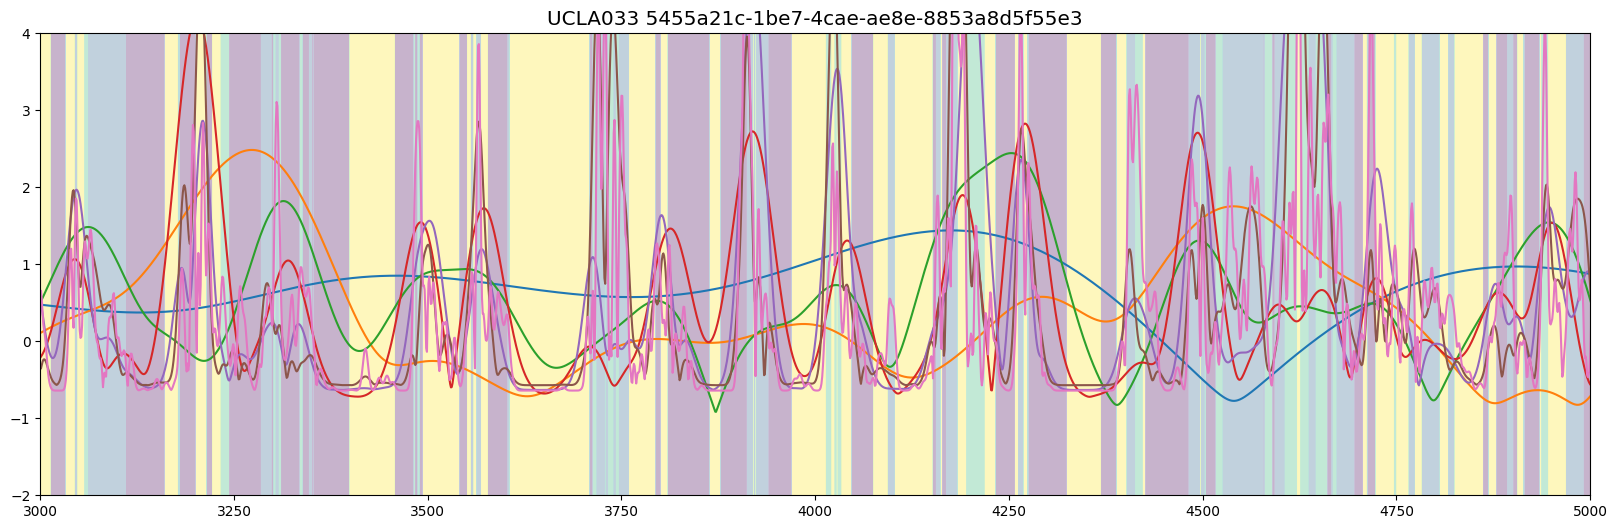

UCLA0335455a21c-1be7-4cae-ae8e-8853a8d5f55e


In [9]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

fit = True
kappa=3
num_states=4
num_components = 3
smooth = False
window=6
downsample=False
downsample_factor=10
method='prior'
    

fit_id = str(mouse_name+session)

# Get session data
filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
# Get design_matrix
filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
# Get standardized design_matrix
filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
standardized_designmatrix = np.load(filename+str('.npy'))
filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]

num_timesteps = np.shape(design_matrix)[0]

if fit:
    # Prepare data format
    emission_dim = np.shape(design_matrix)[1]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    # data = np.array(unnorm_design_matrix[var_interest])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)
    if smooth:
        df = pd.DataFrame(data, columns=["Signal"])
        smoothed_signal = df["Signal"].rolling(window=window, center=True).mean().to_numpy()
        shortened_array = np.array(data)
        shortened_array[int(np.ceil(window/2)):-int(np.floor(window/2))] = smoothed_signal[int(np.ceil(window/2)):-int(np.floor(window/2))].reshape(-1, 1)
    else:
        shortened_array = np.array(data)        
    
    if downsample:
        # Downsample
        downsampled = shortened_array[::downsample_factor].copy()
        shortened_array = downsampled[:(np.shape(downsampled)[0] // num_train_batches) * num_train_batches]

    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    
    " Fit model with best params"
    # Initialize new hmm and fit
    gmmhmm = GaussianMixtureHMM(num_states, num_components, emission_dim, transition_matrix_stickiness=kappa)
    # init_params, props = arhmm.initialize(key=jr.PRNGKey(0), method=method, emissions=shortened_array)  # not sure if I need to include  
    all_val_lls, fit_params, init_params, baseline_lls = cross_validate_poismodel(
                        gmmhmm, jr.PRNGKey(0), train_emissions, num_train_batches
                    )


    " Re-fit with parameters of best fold "
    # Find best fold
    use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]

    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    # emission_weights = fit_params[2].weights[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]        

    # Initialize new hmm
    new_gmmhmm = GaussianMixtureHMM(num_states, num_components, emission_dim, transition_matrix_stickiness=kappa)
    best_fold_params, props = new_gmmhmm.initialize(key=jr.PRNGKey(0), method=method,
                                    initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=shortened_array)  # not sure if I need to include
                                    # emission_weights=emission_weights,

    # Get state estimates for validation data
    most_likely_states = new_gmmhmm.most_likely_states(best_fold_params, shortened_array)
    # most_likely_states = hmm.most_likely_states(init_params, shortened_array, my_inputs)

else:
    # Get most likely states
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    most_likely_states, use_fold, best_params = pickle.load(open(result_filename, "rb"))
    state_number, lag_number, kappa_number = best_params
    

" Plots "
# Prepare data
design_matrix_heading = pd.DataFrame(columns=var_names)
design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
design_matrix_heading['Bin'] = bins


if smooth:
    data = design_matrix_heading[var_names].rolling(window=window, center=True).median()
else:
    data = design_matrix_heading[var_names]
    
# Plot raw trace over states
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)
ax.plot(data)
ax.imshow(np.concatenate([most_likely_states])[None,:], 
            extent=(0, len(np.concatenate([most_likely_states])), -4, 4),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
if fit:
    ax.set_title(mouse_name+' '+session+str(kappa))
else:
    ax.set_title(mouse_name+' '+session+str(kappa_number))
    
init = 3000
ax.set_xlim([init, init+2000])
ax.set_ylim([-2, 4])
plt.show()
print(fit_id)

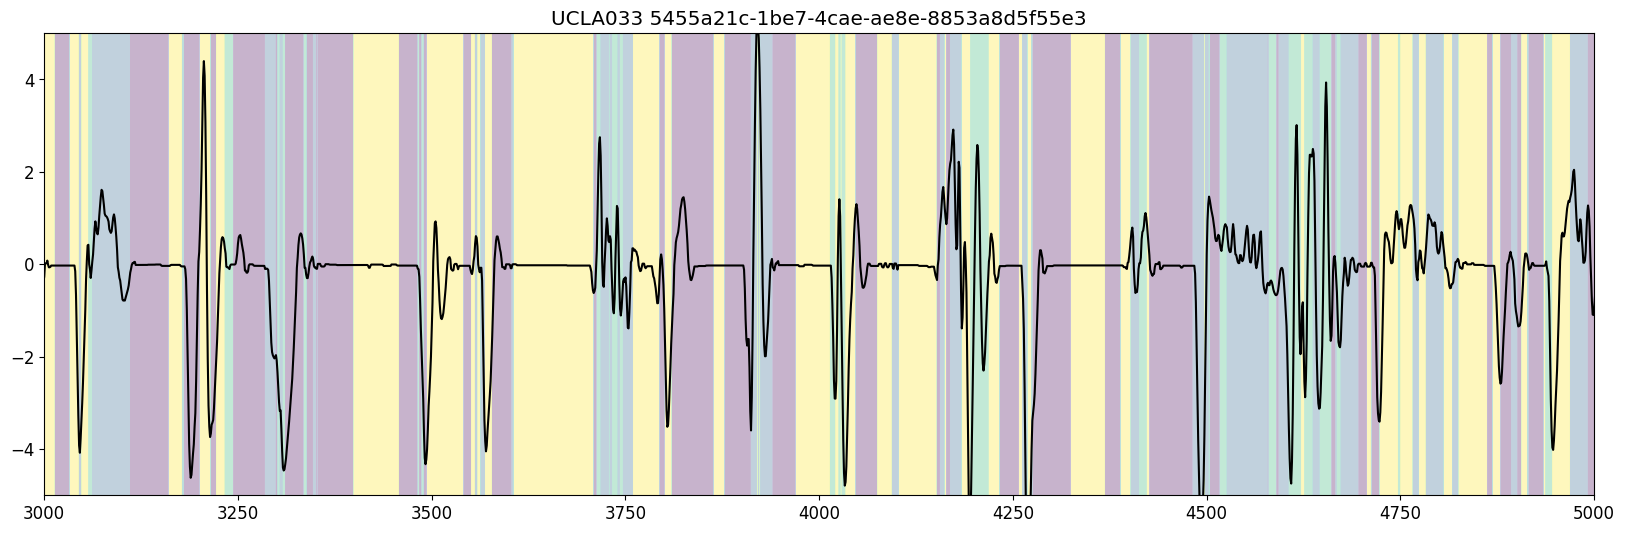

In [11]:
# Plot raw trace over states
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)

# ax.plot(data)
ax.plot(filtered_matrix[:len(data), 0], color='black')
ax.imshow(np.concatenate([most_likely_states])[None,:], 
            extent=(0, len(np.concatenate([most_likely_states])), -5, 5),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 

if fit:
    ax.set_title(mouse_name+' '+session+str(kappa))
else:
    ax.set_title(mouse_name+' '+session+str(kappa_number))
    
init = 3000
ax.set_xlim([init, init+2000])
ax.set_ylim([-5, 5])

plt.show()